# 03 — Baselines (Linear Regression & XGBoost) + Simple Backtest
เทรนโมเดลพื้นฐาน → ประเมิน RMSE/MAE/R² → แปลงเป็นสัญญาณ long/short → กลับทดสอบแบบง่าย

In [1]:

# --- Setup ---
%pip -q install pandas numpy matplotlib scikit-learn xgboost


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load processed dataset from step 02
df = pd.read_csv("dataset_features_labels.csv", index_col=0, parse_dates=True)

# Recreate time split
features = [c for c in df.columns if c != "Target"]
X = df[features]
y = df["Target"]
n = len(df)
n_train = int(n*0.7)
n_val   = int(n*0.85)
X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_val,   y_val   = X.iloc[n_train:n_val], y.iloc[n_train:n_val]
X_test,  y_test  = X.iloc[n_val:], y.iloc[n_val:]


In [4]:

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse_compat(y_true, y_pred):
    # บางเวอร์ชันของ sklearn ไม่มีพารามิเตอร์ squared
    mse = mean_squared_error(np.asarray(y_true).ravel(),
                             np.asarray(y_pred).ravel())
    return np.sqrt(mse)

def metrics_table(y_true, preds_dict):
    y_true = np.asarray(y_true).ravel()
    rows = []
    for name, pred in preds_dict.items():
        pred = np.asarray(pred).ravel()
        rows.append({
            "Model": name,
            "RMSE": rmse_compat(y_true, pred),
            "MAE": mean_absolute_error(y_true, pred),
            "R2": r2_score(y_true, pred),
            "Directional_Acc": (np.sign(y_true) == np.sign(pred)).mean()
        })
    return pd.DataFrame(rows)

metrics = metrics_table(y_test.values, {
    "LinearRegression": y_pred_lr,
    "XGBoost": y_pred_xgb
})
print(metrics)
metrics.to_csv("model_comparison_metrics.csv", index=False)
print("Saved: model_comparison_metrics.csv")



              Model      RMSE       MAE        R2  Directional_Acc
0  LinearRegression  0.009889  0.007193 -0.044005         0.524675
1           XGBoost  0.010687  0.007606 -0.219114         0.516883
Saved: model_comparison_metrics.csv


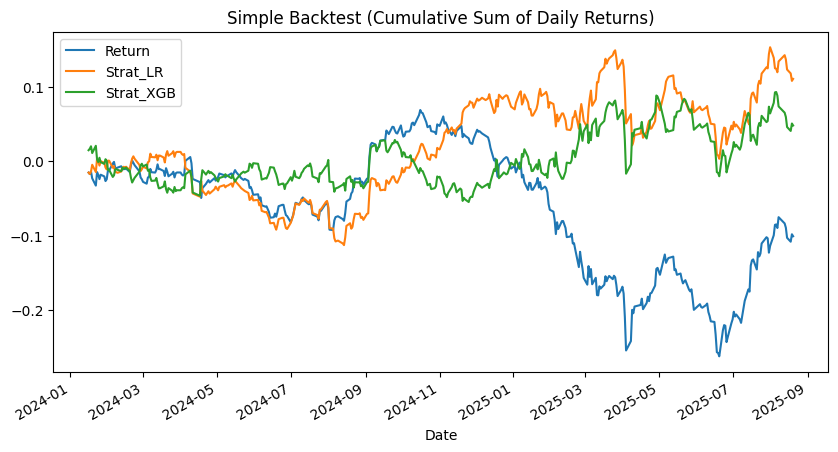

Saved: backtest_simple_signals.csv


In [5]:

# --- Simple backtest: convert predictions to signals (long/short) ---
test_index = y_test.index
signals = pd.DataFrame(index=test_index)
signals["Return"] = y_test.values
signals["Pred_LR"]  = np.where(y_pred_lr > 0, 1, -1)
signals["Pred_XGB"] = np.where(y_pred_xgb > 0, 1, -1)
signals["Strat_LR"]  = signals["Pred_LR"]  * signals["Return"]
signals["Strat_XGB"] = signals["Pred_XGB"] * signals["Return"]

# Cumulative sum of returns as proxy (no compounding here for simplicity)
signals[["Return","Strat_LR","Strat_XGB"]].cumsum().plot(title="Simple Backtest (Cumulative Sum of Daily Returns)", figsize=(10,5))
plt.show()

# Save strategy series
signals.to_csv("backtest_simple_signals.csv")
print("Saved: backtest_simple_signals.csv")


## Portfolio Prep (W1–2): Mean & Covariance for Sample Universe

In [7]:

import yfinance as yf

TICKERS = ["PTT.BK","AOT.BK","SCB.BK","CPALL.BK","ADVANC.BK"]
START = "2015-01-01"
END   = "2025-08-22"

prices = yf.download(TICKERS, start=START, end=END)["Close"].ffill().dropna()
rets = prices.pct_change().dropna()

mean_returns = rets.mean()
cov_matrix = rets.cov()

mean_returns.to_csv("portfolio_mean_returns.csv", header=["mean_return"])
cov_matrix.to_csv("portfolio_cov_matrix.csv")

print("Saved portfolio_mean_returns.csv and portfolio_cov_matrix.csv")
print("Mean Returns (head):\n", mean_returns.head())
print("\nCov Matrix (shape):", cov_matrix.shape)


/tmp/ipython-input-3432330765.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(TICKERS, start=START, end=END)["Close"].ffill().dropna()
[*********************100%***********************]  5 of 5 completed

Saved portfolio_mean_returns.csv and portfolio_cov_matrix.csv
Mean Returns (head):
 Ticker
ADVANC.BK    0.000619
AOT.BK      -0.000555
CPALL.BK    -0.000290
PTT.BK       0.000099
SCB.BK       0.001035
dtype: float64

Cov Matrix (shape): (5, 5)


> ✅ ผลลัพธ์ที่ควรได้: model_comparison_metrics.csv, backtest_simple_signals.csv, portfolio_mean_returns.csv, portfolio_cov_matrix.csv